## Clustering

Clustering is the act of letting data describe itself when it doesn't have any natural means by which to classify it. This is a method of arranging items so that similar items are in one cluster and dissimilar items are in distinct ones. The first thing we need to do is transform text into something on which we can calculate similarity. We can leverage a similarity measurement to cluster similar texts. This can be done with the marvelous Scikit-Learn library

    - One text similarity measure is the Levenshtein distance, which also goes by the name Edit Distance. 
    - Let's say we have two words, "machine" and "mchiene". 
    - The similarity between them can be expressed as the minimum set of edits that are necessary to turn
      one word into the other.
    - In this case, the edit distance will be 2, as we have to add an "a" after the "m" and delete the first "e". 

This algorithm (**Edit Distance**) is, however, quite costly as it is bound by the length of the first word times the length of the second word.

More robust than edit distance is **bag-of-words**, also known as vectorization. It ignores the order of words and simply uses word counts as the basis.

This exercise uses text corpa available from http://mlcomp.org/datasets/379

In [1]:
# This code based on supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

import os
import sys
import scipy as sp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer(min_df=1)
print(vectorizer)

content = ['The world is a mess and I just need to rule it',
           'Everybody is a mess and the world needs them to rule it']

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


Now, we can pull this list of subject lines into the fit_transform() function of the vectorizer, which will do the major lifting

In [2]:
X = vectorizer.fit_transform(content)
print(vectorizer.get_feature_names())
print()
print(X.toarray())

['and', 'everybody', 'is', 'it', 'just', 'mess', 'need', 'needs', 'rule', 'the', 'them', 'to', 'world']

[[1 0 1 1 1 1 1 0 1 1 0 1 1]
 [1 1 1 1 0 1 0 1 1 1 1 1 1]]


### Counting Words

In [3]:
DATA_DIR = os.path.join("C:\JupyterNotebook\MachineLearningPractice\MachineLearningWithPython\ch03\data")

if not os.path.exists(DATA_DIR):
    print("Uh, we were expecting a data directory, which contains the toy data")
    sys.exit(1)

CHART_DIR = os.path.join("charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)
    
TOY_DIR = os.path.join(DATA_DIR, "toy")
posts = [open(os.path.join(TOY_DIR, f)).read() for f in os.listdir(TOY_DIR)]

import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')

In [4]:
vectorizer = CountVectorizer(min_df=1)
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print("# Samples: %d, # Features: %d" % (num_samples, num_features))
print(vectorizer.get_feature_names())

# Samples: 5, # Features: 25
['about', 'actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'is', 'it', 'learning', 'machine', 'most', 'much', 'not', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'this', 'toy']


This shows up a total of 5 posts with a total of 25 words, or features. Next we can vectorize the new post based on the .txt samples in the toy directory

In [5]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])  #Array input makes word iterable

For a naïve similarity measurement, we calculate the Euclidean distance between the count vectors of the new post and all the old posts using a couple of simple functions and scipy

In [6]:
def dist_raw(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())

In [7]:
def dist_norm(v1, v2):
    v1_normalized = v1 / sp.linalg.norm(v1.toarray())
    v2_normalized = v2 / sp.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized
    return sp.linalg.norm(delta.toarray())

In [8]:
def dist_calc(dist, new_post_vec, X_train):
    best_dist = sys.maxsize
    best_i = None

    for i in range(0, num_samples):
        post = posts[i]
        if post == new_post:
            continue
        post_vec = X_train.getrow(i)
        d = dist(post_vec, new_post_vec)

        print("=== Post %i with dist=%.2f: %s" % (i, d, post))

        if d < best_dist:
            best_dist = d
            best_i = i

    print("Best post is %i with dist=%.2f" % (best_i, best_dist))

In [9]:
def test_vectorizer(vectorizer):
    print(sorted(vectorizer.get_stop_words())[0:20])
    print()
    X_train = vectorizer.fit_transform(posts)
    num_samples, num_features = X_train.shape
    print("# Samples: %d, # Features: %d" % (num_samples, num_features))

    print(vectorizer.get_feature_names())
    print()

    new_post_vec = vectorizer.transform([new_post])  #Array input makes word iterable
    print(new_post_vec)
    dist = dist_calc(dist_norm, new_post_vec, X_train)
    print(dist)

Here it makes more sense to use a normalized function to test against our data, since that will give use a better result. Looking at the normalized distribution of these small texts shows that post with index 3 is the most normalized, whereas the post in index 0 is the most irregular.

When we look more closely at the posts in 3 and 4, we can see that they are not exact in the same. In fact, the post in index 4 is the same text in index 3 repeated 3 times and index 4 has a much higher dist rating since this is not normalized.

In [10]:
dist = dist_calc(dist_raw, new_post_vec, X_train)
print(dist)

=== Post 0 with dist=4.00: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=1.73: Imaging databases provide storage capabilities.
=== Post 2 with dist=2.00: Most imaging databases save images permanently.

=== Post 3 with dist=1.41: Imaging databases store data.
=== Post 4 with dist=5.10: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=1.41
None


When we look more closely at posts with index 3 and 4, we see that 4 is the exact same text as 3, just repeated 3 times. In order to account for this, we need to normalize the word count vectors. Doing this gives both posts a dist score of .77

In [11]:
dist2 = dist_calc(dist_norm, new_post_vec, X_train)
print(dist2)

=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.92: Most imaging databases save images permanently.

=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=0.77
None


### Removing Filler Words

Many words don't carry a whole lot of context or entropy. Other words appear often and in many different context. These are known as **stop words**, and are generally best removed prior to analysis. This is such a common function, that it's build into the CountVectorizer.

Fitting the posts to the vectorizer using stop words gives us 18 features instead of 25, and brings for normalized dist scores of posts 1 and 2 both to .86.

In [12]:
vectorizer2 = CountVectorizer(min_df=1, stop_words='english')
test_vectorizer(vectorizer2)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst']

# Samples: 5, # Features: 18
['actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'learning', 'machine', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'toy']

  (0, 4)	1
  (0, 6)	1
=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.86: Most imaging databases save images permanently.

=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=0.77
None


### Stemming and NLTK

(See additional exploration and practice for text and language processing using Natural Language Toolkit (NLTK) for Python here: https://github.com/WhitneyOnTheWeb/Python_Playground/tree/master/NLTK)

When we examing the 18 words from the output from the posts text, we can see we get both 'imaging' and 'images'. In many contexts, and for the purposes of this exploration it makes the most sense to treat them both as their stem word, 'imag'. For that, we rely on the NLTK library, since SciKit does not have a built in word stemmer.

In [13]:
import nltk.stem

english_stemmer = nltk.stem.SnowballStemmer('english')

'''
Creates a StemmedCountVectorizer Class, which does the following for each post:

1. lower casing raw post in the preprocessing step (done in the parent class).

2. Extracting all individual words in the tokenization step (done in the
parent class).

3. concludes with converting each word into its stemmed version.
'''
class StemmedCountVectorizer(CountVectorizer):

    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

'''
Creates a StemmedTfidVectorizer Class, which does the following for each post:

1. Firstly, tokenizing the text.
2. This is followed by throwing away words that occur way too often to be of
any help in detecting relevant posts.
3. Throwing away words that occur way so seldom so that there is only little
chance that they occur in future posts.
4. Counting the remaining words.
5. Finally, calculating TF-IDF values from the counts, considering the whole
text corpus.
'''
class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

#### Testing CountVector Stemming

In [14]:
vectorizer3 = StemmedCountVectorizer(min_df=1, stop_words='english')
test_vectorizer(vectorizer3)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst']

# Samples: 5, # Features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']

  (0, 4)	1
  (0, 5)	1
=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.63: Most imaging databases save images permanently.

=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 2 with dist=0.63
None


#### Testing TfidVector Stemming

term frequency – inverse document frequency (TF-IDF)

Count the terms, but also normalize the counts by the document length. This ensures that documents of a longer word length don't have an advantage over those with shorter ones.

In [15]:
vectorizer4 = StemmedTfidfVectorizer(
    min_df=1, stop_words='english', decode_error='ignore')
test_vectorizer(vectorizer4)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst']

# Samples: 5, # Features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']

  (0, 5)	0.707106781187
  (0, 4)	0.707106781187
=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=1.08: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.86: Most imaging databases save images permanently.

=== Post 3 with dist=0.92: Imaging databases store data.
=== Post 4 with dist=0.92: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 2 with dist=0.86
None


**While vectorizer4 acheives the goals set fouth by the StemmedTfidfVectorizer, there are several pitfalls:**

**1. It doesn't account for related words**
  - 'car hits wall' and 'wall hits car', with would present the same feature vector
  
**2. It doesn't capture negations correctly**
 
  - 'I will eat ice cream' and 'I will not eat ice cream' appear very similarly, although they have opposite meaning
  - This can be solved by counting individual words (**unigrams**), but pairs of words (**bigrams**), and three words in a row (**trigrams**)
  
**3. Treats mispelled words as different words**
 
With these limitations in mind, we will stick with the current approach for the sake of this current exploration.  At this point vectorizer4 captures the posts sufficiently enough to proceed onto clustering. Clustering is done is one or two ways:

### Clustering Structures

#### Flat

 - Divides the data into a set of clusters without relating the clujsters to each other, and the number of clusters is generally specified up front.
 - The goal is  to come up with partitioning such that all data in a cluster are similar to each other, while being dissimilar to from data in other clusters.
 
#### Hierachial

 - A hierachy of an unspecificed number of clusters is created related to each other
 - Similar data is grouped into one cluster, and similar clusters are grouped into an uber-cluster, which is done recursively until a single cluster is left containing all clusters
 - Number of clusters can be set after the fact, but comes at the cost of efficiency
 
 
### K-means

k-means is the most widely used flat clustering algorithm. After initializing it with the desired number of clusters, num_clusters, it maintains that number of so-called cluster centroids.

In [16]:
from scipy.stats import norm
from matplotlib import pylab
from sklearn.cluster import KMeans

seed = 2
sp.random.seed(seed) # static seed to reproduce data

num_clusters = 3

In [17]:
def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    pylab.figure(num=None, figsize=(8, 6))
    if km:
        pylab.scatter(x, y, s=50, c=km.predict(list(zip(x, y))))
    else:
        pylab.scatter(x, y, s=50)

    pylab.title(title)
    pylab.xlabel("Occurrence word 1")
    pylab.ylabel("Occurrence word 2")

    pylab.autoscale(tight=True)
    pylab.ylim(ymin=0, ymax=1)
    pylab.xlim(xmin=0, xmax=1)
    pylab.grid(True, linestyle='-', color='0.75')

    return pylab

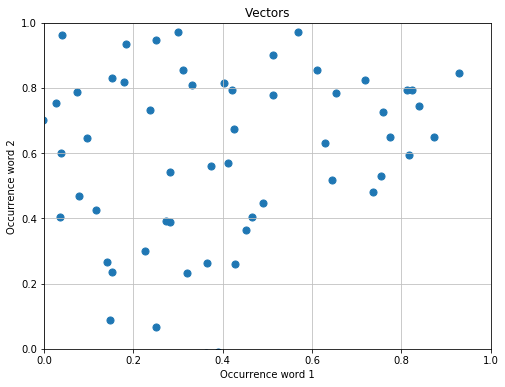

In [20]:
xw1 = norm(loc=0.3, scale=.15).rvs(20)
yw1 = norm(loc=0.3, scale=.15).rvs(20)

xw2 = norm(loc=0.7, scale=.15).rvs(20)
yw2 = norm(loc=0.7, scale=.15).rvs(20)

xw3 = norm(loc=0.2, scale=.15).rvs(20)
yw3 = norm(loc=0.8, scale=.15).rvs(20)

x = sp.append(sp.append(xw1, xw2), xw3)
y = sp.append(sp.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")
pylab.savefig(os.path.join(CHART_DIR, "1400_03_01.png"))
pylab.show()
pylab.clf()

The following scatterplot shows posts containing only 2 words. Each point represents a single document

Next, we will run the first iteration of the k-means algorithm, by taking any two vectors as the starting point, then giving labels to the rest, and then updating the cluster centers to be the center point of all points in that cluster. This gives us the following graph:

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2.91878071793


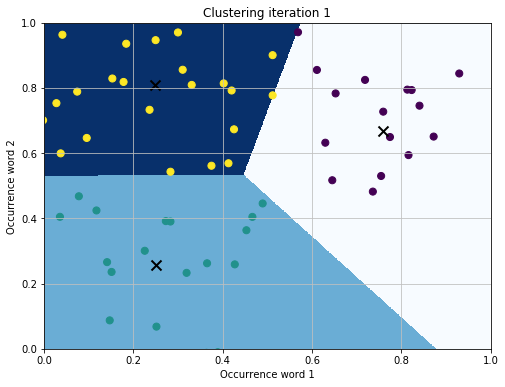

In [21]:
mx, my = sp.meshgrid(sp.arange(0, 1, 0.001), sp.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))

Z = km.predict(sp.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
pylab.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=pylab.cm.Blues,
             aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
pylab.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
pylab.savefig(os.path.join(CHART_DIR, "1400_03_02.png"))
pylab.show()
pylab.clf()

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2.91878071793
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.73210002537
start iteration
done sorting
end inner loop
Iteration 2, inertia 2.72300621413
start iteration
done sorting
end inner loop
Iteration 3, inertia 2.72300621413
center shift 0.000000e+00 within tolerance 7.704931e-06


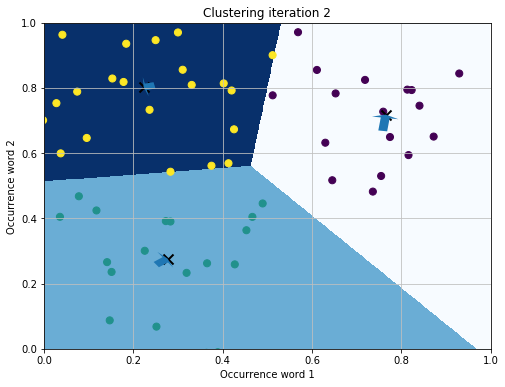

In [22]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=5,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))

Z = km.predict(sp.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
pylab.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=pylab.cm.Blues,
             aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
pylab.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

# Draw arrows on axis to follow direction of cluster center movement
pylab.gca().add_patch(
    pylab.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1))

pylab.savefig(os.path.join(CHART_DIR, "1400_03_04.png"))
pylab.show()
pylab.clf()

The arrows show the movements of the cluster centers. After five iterations in this example, the cluster centers don't move noticeably any more than what is shown here.

After the clustering has settled, we just need to note down the cluster centers and their identity. Each new document that comes in, we then have to vectorize and compare against all cluster centers. The cluster center with the smallest distance to our new post vector belongs to the cluster we will assign to the new post.


Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1.42115054055
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1.42115054055
start iteration
done sorting
end inner loop
Iteration 1, inertia 1.2145522935
start iteration
done sorting
end inner loop
Iteration 2, inertia 1.16732692157
start iteration
done sorting
end inner loop
Iteration 3, inertia 1.07091979722
start iteration
done sorting
end inner loop
Iteration 4, inertia 1.07091979722
center shift 0.000000e+00 within tolerance 7.704931e-06


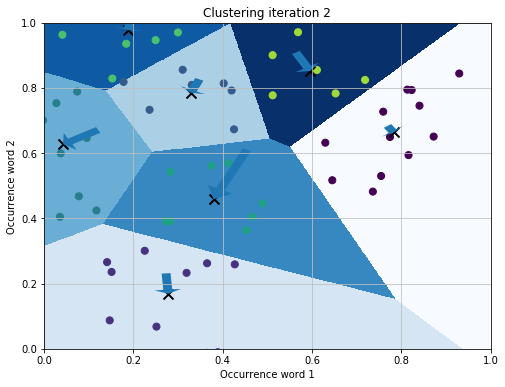

In [23]:
# Get cluster centers for 1 iterations of K-means with 8 clusters
km = KMeans(init='random', n_clusters=8, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))
c1a, c1b, c1c, c1d, c1e, c1f, c1g, c1h = km.cluster_centers_

#
km = KMeans(init='random', n_clusters=8, verbose=1,
            n_init=1, max_iter=5,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))

Z = km.predict(sp.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
pylab.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=pylab.cm.Blues,
             aspect='auto', origin='lower')

c2a, c2b, c2c, c2d, c2e, c2f, c2g, c2h = km.cluster_centers_
pylab.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

# Draw arrows on axis to follow direction of cluster center movement
# Fix this with a loop, very silly programming here
pylab.gca().add_patch(
    pylab.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1d[0], c1d[1], c2d[0] - c1d[0], c2d[1] - c1d[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1e[0], c1e[1], c2e[0] - c1e[0], c2e[1] - c1e[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1f[0], c1f[1], c2f[0] - c1f[0], c2f[1] - c1f[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1g[0], c1g[1], c2g[0] - c1g[0], c2g[1] - c1g[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1h[0], c1h[1], c2h[0] - c1h[0], c2h[1] - c1h[1], width=0.1))

pylab.savefig(os.path.join(CHART_DIR, "1400_03_05.png"))
pylab.show()
pylab.clf()


Now for fun, lets see what this looks like with a higher number of clusters, and a higher number of iterations.  It appears that some cluster centers didn't move at all, while others moved quite a long ways.


## 20newsgroup Dataset

To really test clustering, we need to move beyond the tiny toy dataset, and into something more robust. ```20newsgroup``` is a well known dataset provided by MLcomp, and integrated with SciKit that contains 18,826 posts from 20 different usenet news groups, spannings topics such as technology, politics, and religion.

Assuming each newsgroup to be one cluster, we can test to see if our approach to finding related posts works.

In [24]:
import sklearn.datasets

groups = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space']

data = sklearn.datasets.fetch_20newsgroups(subset='all')
print("Number of total posts: %i" % len(data.filenames))
print()

train_data = sklearn.datasets.fetch_20newsgroups(subset = 'train',
                                                 categories=groups)
print("Number of training posts in tech groups:", len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset = 'test',
                                                categories=groups)
print("Number of testing posts in tech groups:", len(test_data.filenames))

Number of total posts: 18846

Number of training posts in tech groups: 3529
Number of testing posts in tech groups: 2349


Since real data contains a lot of noise, it becomes important to be able to filter it out, and read around it. In this case, there are things such as invalid characters that stand out right away and will cause errors in the vectorizer unless we explicitly set it to ignore them.

In [25]:
vectorizer5 = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                     stop_words='english', 
                                     decode_error='ignore')
vectorized = vectorizer5.fit_transform(train_data.data)
num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))


#samples: 3529, #features: 4712


We now have a pool of 3,529 posts and extracted for each of them a feature vector of 4,712 dimensions. That is what K-means takes as input. We will fix the cluster size to 50

In [35]:
num_clusters = 50
km5 = KMeans(n_clusters=num_clusters, init='random', 
             n_init=1, verbose=1, random_state=3)
km5.fit(vectorized)
labels = train_data.target


# Vital Statistics 

print("km.labels_=%s" % km5.labels_)
print("km.labels_.shape=%s" % km5.labels_.shape)
from sklearn import metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km5.labels_))
# Homogeneity: 0.400
print("Completeness: %0.3f" % metrics.completeness_score(labels, km5.labels_))
# Completeness: 0.206
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km5.labels_))
# V-measure: 0.272
print("Adjusted Rand Index: %0.3f" %
      metrics.adjusted_rand_score(labels, km5.labels_))
# Adjusted Rand Index: 0.064
print("Adjusted Mutual Information: %0.3f" %
      metrics.adjusted_mutual_info_score(labels, km5.labels_))
# Adjusted Mutual Information: 0.197
print(("Silhouette Coefficient: %0.3f" %
       metrics.silhouette_score(vectorized, labels, sample_size=1000)))
# Silhouette Coefficient: 0.006

#Cluster Centers
print(km5.cluster_centers_)

Initialization complete
Iteration  0, inertia 5899.560
Iteration  1, inertia 3218.298
Iteration  2, inertia 3184.333
Iteration  3, inertia 3164.867
Iteration  4, inertia 3152.004
Iteration  5, inertia 3143.111
Iteration  6, inertia 3136.256
Iteration  7, inertia 3129.325
Iteration  8, inertia 3124.567
Iteration  9, inertia 3121.900
Iteration 10, inertia 3120.210
Iteration 11, inertia 3118.627
Iteration 12, inertia 3117.363
Iteration 13, inertia 3116.811
Iteration 14, inertia 3116.588
Iteration 15, inertia 3116.417
Iteration 16, inertia 3115.760
Iteration 17, inertia 3115.374
Iteration 18, inertia 3115.155
Iteration 19, inertia 3114.949
Iteration 20, inertia 3114.515
Iteration 21, inertia 3113.937
Iteration 22, inertia 3113.720
Iteration 23, inertia 3113.548
Iteration 24, inertia 3113.475
Iteration 25, inertia 3113.447
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.069005e-08
km.labels_=[38 17 47 ..., 41 14 16]
km.labels_.shape=3529
Homogeneity: 0.428
Completene

### Vectorizing a New Post

Now we return to the initial challenge of vectorizing and clustering new posts by testing how well our algorithm can place test posts. We have to vecotrize the new post, then compare it to all posts in the same cluster based on index. The comparison in the bracket results in a Boolean array, and nonzero converts that array into a smaller array containing the indices of the True elements.

In [36]:
new_post = \
    """Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
"""
    
new_post_vec = vectorizer5.transform([new_post])
new_post_label = km5.predict(new_post_vec)[0]

similar_indices = (km5.labels_ == new_post_label).nonzero()[0]
print(similar_indices)

[  66   69  125  139  157  167  201  213  214  225  228  233  247  308  351
  354  355  359  370  384  392  395  428  429  446  453  463  479  531  533
  548  563  580  581  618  619  676  689  714  779  806  807  808  882  905
  935  939  944  961  964  976  987 1005 1076 1114 1221 1242 1246 1250 1257
 1266 1286 1309 1313 1316 1388 1389 1427 1431 1481 1486 1487 1512 1519 1538
 1548 1608 1624 1637 1670 1716 1752 1769 1806 1840 1843 1852 1864 1893 1986
 1990 1996 2013 2061 2085 2139 2151 2223 2235 2257 2270 2277 2283 2306 2347
 2351 2357 2400 2412 2414 2436 2443 2447 2463 2475 2493 2512 2516 2518 2525
 2539 2565 2573 2600 2612 2624 2651 2667 2678 2705 2745 2791 2800 2815 2842
 2852 2875 2907 2947 2951 2956 2964 2993 2995 3018 3026 3060 3065 3145 3146
 3160 3173 3186 3192 3199 3202 3214 3219 3225 3285 3289 3296 3297 3309 3437
 3450]


Now that we have similar_indices, we can use it to build a list of posts together based on their similarity scores. This shows the top three out of 166 post found that were similar, with their corresponding similarity scores.We can see the first post revolves around the same topic as out new post, the second is also around booting problems, but pertains to floppy disks instead of hard disks, and the third isn't about boot errors, but is in the same realm of hard drives.

In [37]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

similar = sorted(similar)
print("Count similar: %i" % len(similar))

show_at_1 = similar[0]
show_at_2 = similar[int(len(similar) / 10)]
show_at_3 = similar[int(len(similar) / 2)]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

Count similar: 166
=== #1 ===
(1.0378441731334072, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel           

### Clearing the Noise

Clustering is never going to be perfect, however we can always clean it up and eliminate what we might come to consider useless noise that is prevalent is online communities, or even from computer generated output.

In [42]:
post_group = zip(train_data.data, train_data.target)

#Create a list of tuples that can be sorted by post length
all = [(len(post[0]), post[0], train_data.target_names[post[1]])
       for post in post_group]

graphics = sorted([post for post in all if post[2] == 'comp.graphics'])
print(graphics[5])
print()

noise_post = graphics[5][1]

analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))
print()

useful = set(analyzer(noise_post)).intersection(vectorizer5.get_feature_names())
print(sorted(useful))
print()

for term in sorted(useful):
    print('IDF(%s)=%.2f' % (term,
                            vectorizer5._tfidf.idf_[vectorizer5.vocabulary_[term]]))

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')

['from', 'situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorry', 'organization', 'the', 'university', 'of', 'birmingham', 'united', 'kingdom', 'lines', 'nntp', 'posting', 'host', 'ibm3090', 'bham', 'ac', 'uk']

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'test', 'uk']

IDF(ac)=3.51
IDF(birmingham)=6.77
IDF(host)=1.74
IDF(kingdom)=6.68
IDF(nntp)=1.77
IDF(test)=3.83
IDF(uk)=3.70


The higher TF-IDF, the more discriminative a term is for a given post. As IDF is a multiplicative factor here, a low value of it signals that it is not of great value in general.